# Spotify Data Analysis (Unified Data)

## 1. Introduction
In this notebook, we will:
1. Load two datasets extracted from our SQLite database: `Data/extracted_final.csv` and `Data/extracted_cleaned.csv`.
2. **Merge and Clean** them to create a unified dataset.
3. Perform **Advanced EDA** (Time trends, Top Artists, Content types).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

# Set visualization style
sns.set_theme(style="whitegrid")
%matplotlib inline

# Ensure Report directory exists for plots
if not os.path.exists('Report'):
    os.makedirs('Report')

## 2. Load & Merge Data

In [2]:
try:
    import sqlite3

    # Connect to the SQLite database
    db_path = 'Data/spotify.db'
    conn = sqlite3.connect(db_path)
    print(f"Connected to database: {db_path}")

    # SQL Query to combine datasets using UNION ALL (Hybrid Approach: SQL for loading/combining)
    query = """
    -- Improved Query with explicit column alignment
    SELECT track_id, track_name, track_number, track_popularity, track_duration_ms, explicit, artist_name, artist_popularity, artist_followers, artist_genres, album_id, album_name, album_release_date, album_total_tracks, album_type 
    FROM tracks_final
    UNION ALL
    SELECT track_id, track_name, track_number, track_popularity, CAST(track_duration_min * 60000 AS BIGINT) as track_duration_ms, explicit, artist_name, artist_popularity, artist_followers, artist_genres, album_id, album_name, album_release_date, album_total_tracks, album_type
    FROM tracks_cleaned
    """
    
    # Load data into Pandas DataFrame
    df = pd.read_sql(query, conn)
    conn.close()
    
    print(f"Data loaded from SQL. Shape (before cleaning): {df.shape}")

    # Standardize columns (Pandas processing)
    if 'track_duration_ms' in df.columns and 'track_duration_min' not in df.columns:
        df['track_duration_min'] = df['track_duration_ms'] / 60000
    
    if 'track_duration_min' in df.columns and 'track_duration_ms' not in df.columns:
        df['track_duration_ms'] = df['track_duration_min'] * 60000
    
except Exception as e:
    print(f"Error loading data from SQL: {e}")
    print("Ensure etl_pipeline.py has been run to populate Data/spotify.db")

Connected to database: Data/spotify.db
Data loaded from SQL. Shape (before cleaning): (17360, 15)


## 3. Data Cleaning

In [3]:
# 1. Drop duplicates
if 'track_number' in df.columns and 'track_name' in df.columns:
    initial_rows = len(df)
    # We can try dropping duplicates based on a subset if 'track_id' is missing or unreliable,
    # but assuming track_id is present in both:
    if 'track_id' in df.columns:
         df.drop_duplicates(subset=['track_id'], keep='first', inplace=True)
    else:
         df.drop_duplicates(inplace=True)
    print(f"Removed {initial_rows - len(df)} duplicate rows.")

# 2. Handle missing values
df.dropna(inplace=True)
print(f"Final clean dataset size: {len(df)} rows.")

Removed 8582 duplicate rows.
Final clean dataset size: 8772 rows.


## 4. Advanced Feature Engineering

In [4]:
# Convert Release Date to Year
df['release_year'] = pd.to_datetime(df['album_release_date'], errors='coerce').dt.year

# Filter data with valid years
df = df.dropna(subset=['release_year'])
df['release_year'] = df['release_year'].astype(int)
print("Year extracted successfully.")

Year extracted successfully.


## 6. Advanced Analysis & Findings

### 6.1 Correlation Analysis
Let's look at how different audio features correlate with each other and with popularity.

Top Correlations with Popularity:
track_popularity      1.000000
artist_popularity     0.457493
artist_followers      0.229833
track_duration_ms     0.107335
album_total_tracks   -0.048946
Name: track_popularity, dtype: float64


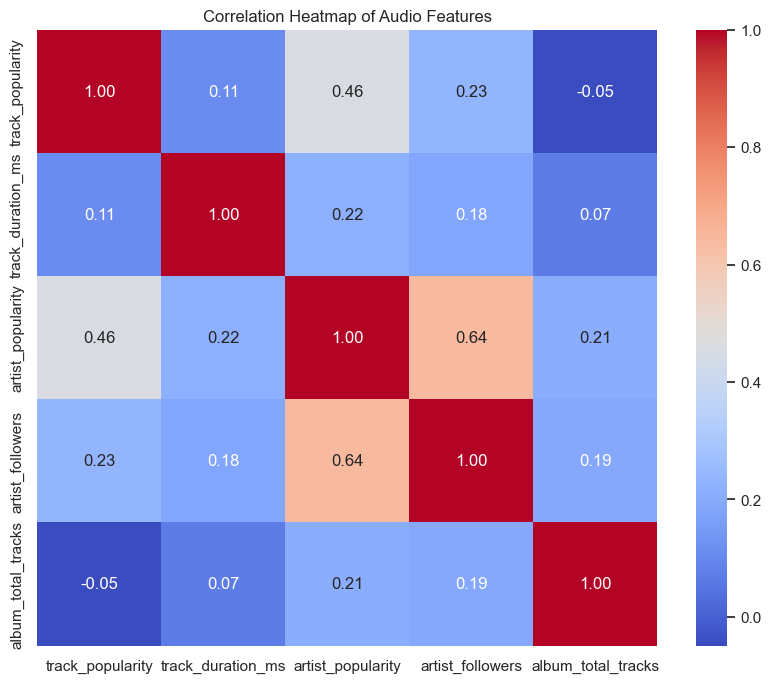

In [5]:
# Select numeric columns for correlation
# Using available numeric columns for correlation
corr_cols = ['track_popularity', 'track_duration_ms', 'artist_popularity', 'artist_followers', 'album_total_tracks']
corr_matrix = df[corr_cols].corr()

# FINDING: Print top correlations
print("Top Correlations with Popularity:")
print(corr_matrix['track_popularity'].sort_values(ascending=False))

# Visualization
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Audio Features')
plt.savefig('Report/plot_correlation.png')
plt.show()

### 6.2 Explicit Content Trends
We analyze the proportion of explicit tracks over the years.


Percentage of Explicit Tracks (Recent 5 Years):
release_year
2021    0.321429
2022    0.296842
2023    0.300952
2024    0.310030
2025    0.278646
Name: 1, dtype: float64


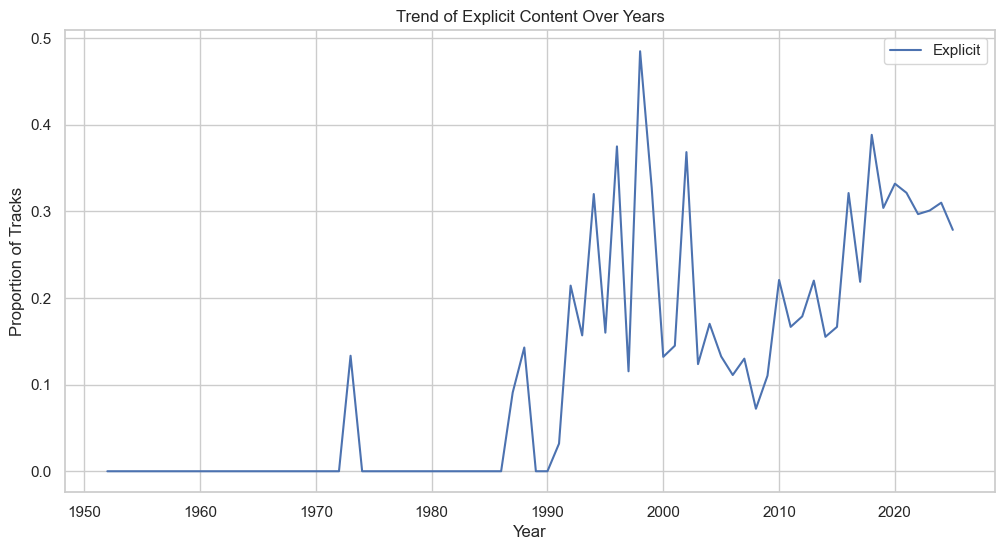

In [6]:
# FINDING: Calculate percentage of explicit tracks per year
# Ensure explicit column is numeric (0/1) to match logic
df['explicit'] = pd.to_numeric(df['explicit'], errors='coerce').fillna(0).astype(int)
explicit_stats = df.groupby('release_year')['explicit'].value_counts(normalize=True).unstack().fillna(0)
if 1 in explicit_stats.columns:
    print("\nPercentage of Explicit Tracks (Recent 5 Years):")
    print(explicit_stats[1].tail(5))

# Visualization
plt.figure(figsize=(12, 6))
if 1 in explicit_stats.columns:
    sns.lineplot(x=explicit_stats.index, y=explicit_stats[1], label='Explicit')
    plt.title('Trend of Explicit Content Over Years')
    plt.ylabel('Proportion of Tracks')
    plt.xlabel('Year')
    plt.savefig('Report/plot_explicit_trend.png')
    plt.show()
else:
    print("No explicit content column found or all false.")

### 6.3 Track Duration Analysis
Are songs getting shorter? Let's check the data.


Average Track Duration (Recent 5 Years):
release_year
2021    3.382618
2022    3.120521
2023    3.105730
2024    3.059914
2025    3.085527
Name: track_duration_min, dtype: float64


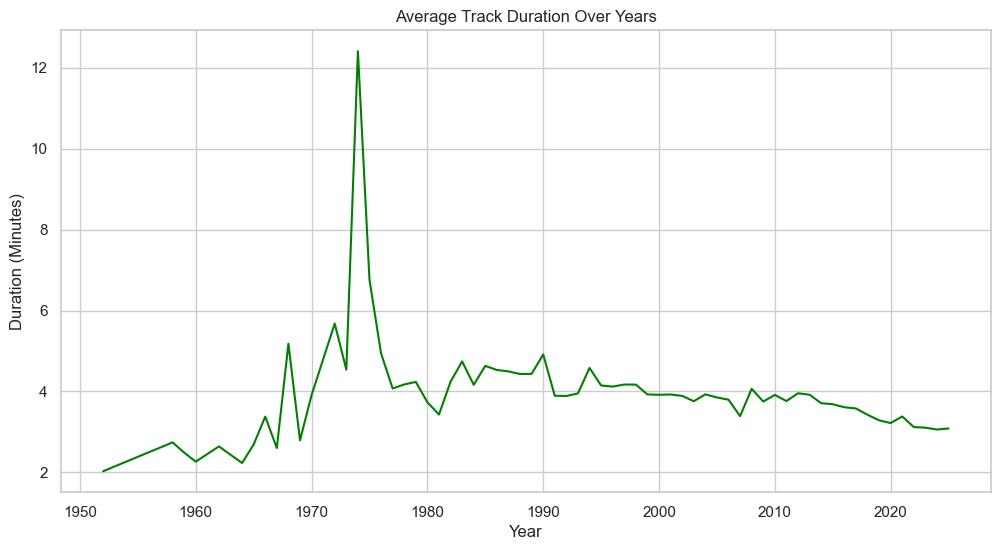

In [7]:
# FINDING: Average duration statistics
avg_duration = df.groupby('release_year')['track_duration_min'].mean()
print("\nAverage Track Duration (Recent 5 Years):")
print(avg_duration.tail(5))

# Visualization
plt.figure(figsize=(12, 6))
sns.lineplot(x=avg_duration.index, y=avg_duration.values, color='green')
plt.title('Average Track Duration Over Years')
plt.xlabel('Year')
plt.ylabel('Duration (Minutes)')
plt.savefig('Report/plot_duration_trend.png')
plt.show()

### 6.4 Popularity Distribution
How is popularity distributed across the tracks?


Popularity Summary Statistics:
count    8573.000000
mean       52.250787
std        24.002797
min         0.000000
25%        39.000000
50%        58.000000
75%        71.000000
max       100.000000
Name: track_popularity, dtype: float64


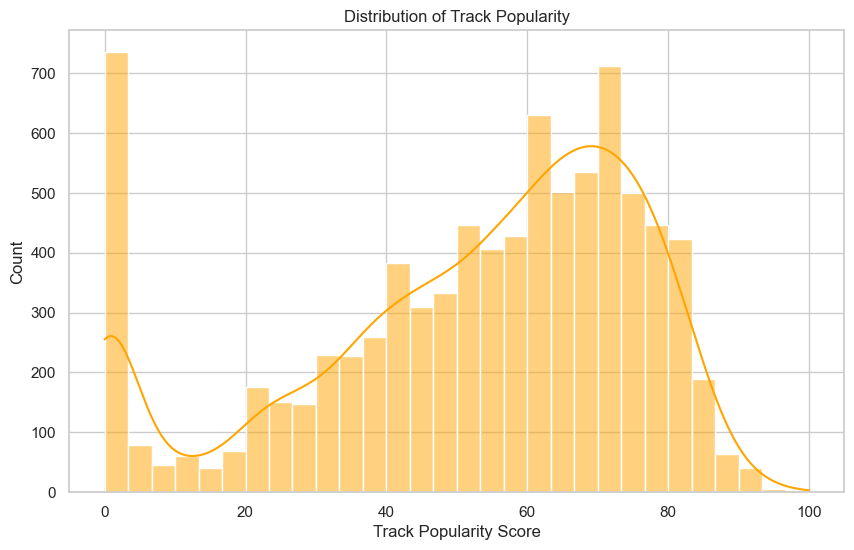

In [8]:
# FINDING: Popularity Statistics
print("\nPopularity Summary Statistics:")
print(df['track_popularity'].describe())

# Visualization
plt.figure(figsize=(10, 6))
sns.histplot(df['track_popularity'], bins=30, kde=True, color='orange')
plt.title('Distribution of Track Popularity')
plt.xlabel('Track Popularity Score')
plt.savefig('Report/plot_popularity_dist.png')
plt.show()

## 5. Visualizations

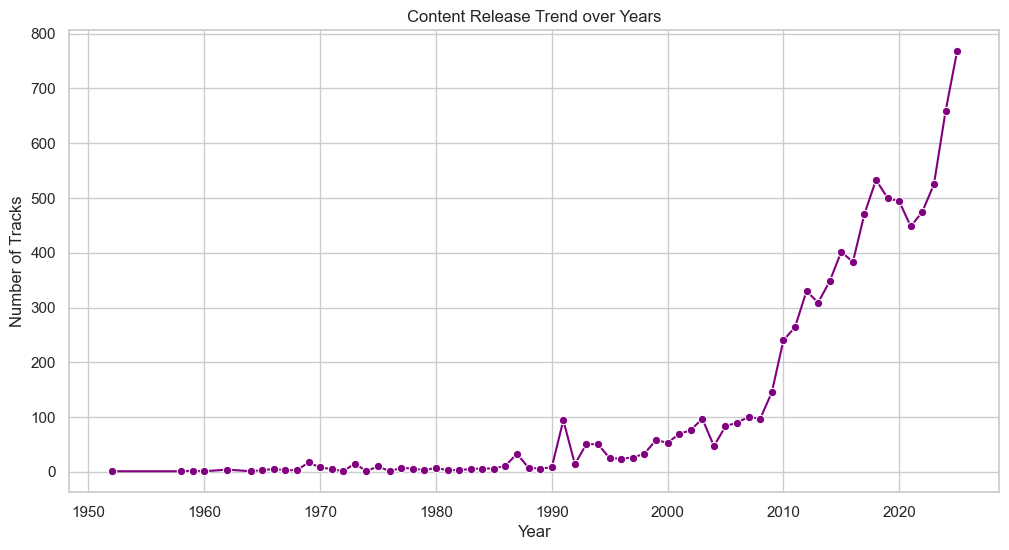

In [9]:
# 1. Time Trend: Number of Tracks per Year
plt.figure(figsize=(12, 6))
tracks_per_year = df['release_year'].value_counts().sort_index()
sns.lineplot(x=tracks_per_year.index, y=tracks_per_year.values, marker='o', color='purple')
plt.title('Content Release Trend over Years')
plt.xlabel('Year')
plt.ylabel('Number of Tracks')
plt.savefig('Report/plot_time_trend.png')
plt.show()

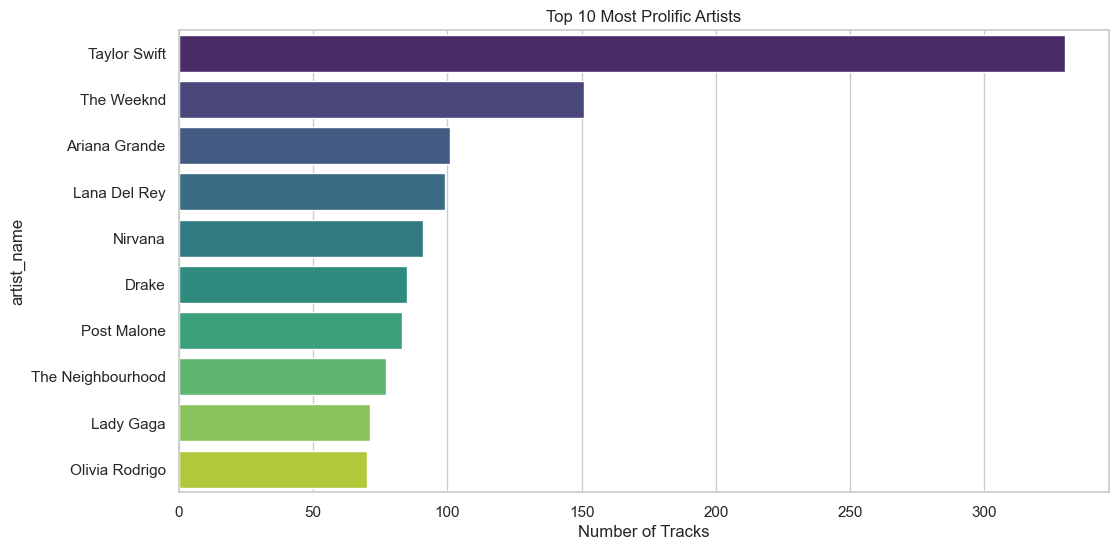

In [10]:
# 2. Top 10 Artists by Track Count
plt.figure(figsize=(12, 6))
top_artists = df['artist_name'].value_counts().head(10)
sns.barplot(y=top_artists.index, x=top_artists.values, palette='viridis', hue=top_artists.index, legend=False)
plt.title('Top 10 Most Prolific Artists')
plt.xlabel('Number of Tracks')
plt.savefig('Report/plot_top_artists.png')
plt.show()

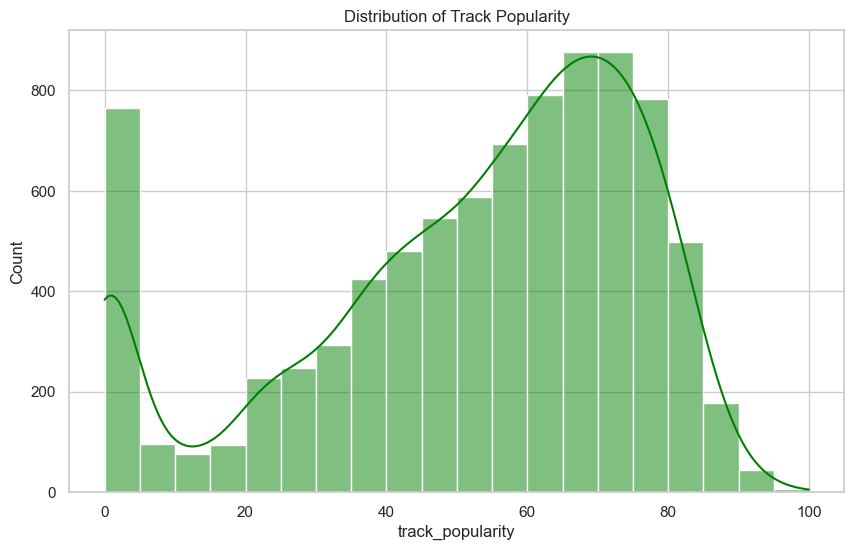

In [11]:
# 3. Popularity Distribution
plt.figure(figsize=(10, 6))
col_pop = 'track_popularity' if 'track_popularity' in df.columns else 'pypopularity'
if col_pop in df.columns:
    sns.histplot(df[col_pop], bins=20, kde=True, color='green')
    plt.title('Distribution of Track Popularity')
    plt.savefig('Report/plot_popularity.png')
    plt.show()
else:
    print("Popularity column not found.")

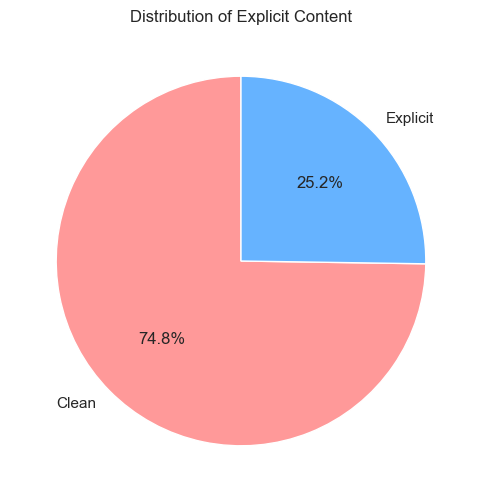

In [12]:
# 4. Explicit vs Clean Content
plt.figure(figsize=(6, 6))
if 'explicit' in df.columns:
    explicit_counts = df['explicit'].value_counts()
    labels = [str(l) for l in explicit_counts.index]
    final_labels = []
    for l in labels:
        if l in ['1', 'True', '1.0']:
            final_labels.append('Explicit')
        elif l in ['0', 'False', '0.0']:
            final_labels.append('Clean')
        else:
            final_labels.append(l)

    plt.pie(explicit_counts, labels=final_labels, autopct='%1.1f%%', colors=['#ff9999','#66b3ff'], startangle=90)
    plt.title('Distribution of Explicit Content')
    plt.savefig('Report/plot_explicit.png')
    plt.show()
else:
    print("Explicit column not found.")

In [13]:
# --- DYNAMIC INSIGHT GENERATION ---
import matplotlib.pyplot as plt

def create_text_slide(title, text, filename):
    fig = plt.figure(figsize=(10, 6))
    plt.text(0.5, 0.7, title, ha='center', va='center', fontsize=20, weight='bold', color='#1DB954')
    plt.text(0.5, 0.4, text, ha='center', va='center', fontsize=14, wrap=True)
    plt.axis('off')
    plt.savefig(filename)
    plt.close()

# 1. Explicit Content Insight
try:
    if 'explicit' in df.columns:
        explicit_prop = df.groupby('release_year')['explicit'].mean()
        max_explicit_year = explicit_prop.idxmax()
        max_explicit_val = explicit_prop.max() * 100
        explicit_text = f"The year with the highest proportion of explicit content was {max_explicit_year}, with {max_explicit_val:.1f}% of tracks marked as explicit."
    else:
        explicit_text = "Explicit content data not available."
except Exception as e:
    explicit_text = f"Could not calculate explicit trends: {e}"

create_text_slide("Explicit Content Trends", explicit_text, "Report/slide_explicit.png")

# 2. Duration Insight
try:
    if 'track_duration_min' in df.columns:
        duration_start = avg_duration.iloc[0]
        duration_end = avg_duration.iloc[-1]
        duration_change = ((duration_end - duration_start) / duration_start) * 100
        duration_text = f"From {avg_duration.index[0]} to {avg_duration.index[-1]}, average track duration changed by {duration_change:.1f}%."
    else:
        duration_text = "Duration data not available."
except Exception as e:
    duration_text = f"Could not calculate duration trends: {e}"

create_text_slide("Track Duration Shifts", duration_text, "Report/slide_duration.png")

# 3. Top Artist Insight
try:
    top_artist_name = top_artists.index[0]
    top_artist_count = top_artists.iloc[0]
    artist_text = f"The most prolific artist in this dataset is {top_artist_name} with {top_artist_count} tracks."
except Exception as e:
    artist_text = f"Could not determine top artist: {e}"

create_text_slide("Key Artist Stats", artist_text, "Report/slide_artist.png")

print("Generated insight slides.")

Generated insight slides.


In [14]:
# Generate Professional PDF Report
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

report_path = 'Report/Spotify_Findings_Report.pdf'
# Interleave slides with plots
report_pages = [
    ('Title', None), # Special handling for title
    ('Executive Summary', 'Report/slide_artist.png'),
    ('Time Trends', 'Report/plot_time_trend.png'),
    ('Popularity Distribution', 'Report/plot_popularity_dist.png'),
    ('Explicit Content Analysis', 'Report/slide_explicit.png'),
    ('Explicit Trend Plot', 'Report/plot_explicit_trend.png'),
    ('Duration Analysis', 'Report/slide_duration.png'),
    ('Duration Trend Plot', 'Report/plot_duration_trend.png'),
    ('Top Artists', 'Report/plot_top_artists.png'),
    ('Correlation Matrix', 'Report/plot_correlation.png')
]

try:
    if not os.path.exists('Report'):
        os.makedirs('Report')
        
    with PdfPages(report_path) as pdf:
        # Title Page
        first_page = plt.figure(figsize=(11.69,8.27))
        first_page.clf()
        first_page.text(0.5, 0.6, 'Spotify Data Analysis', transform=first_page.transFigure, size=24, ha='center', weight='bold')
        first_page.text(0.5, 0.5, 'Comprehensive Findings Report', transform=first_page.transFigure, size=16, ha='center')
        first_page.text(0.5, 0.4, 'Automated Assessment', transform=first_page.transFigure, size=12, ha='center', color='gray')
        pdf.savefig()
        plt.close()

        for title, image_file in report_pages:
            if image_file:
                if os.path.exists(image_file):
                    # Create a new page with the image
                    fig = plt.figure(figsize=(11.69, 8.27))
                    
                    # Add section title
                    plt.figtext(0.5, 0.95, title, ha='center', fontsize=18, weight='bold')
                    
                    img = mpimg.imread(image_file)
                    
                    # Adjust layout based on image aspect ratio if needed, but simple imshow works for full page slides
                    ax = plt.gca()
                    ax.imshow(img)
                    ax.axis('off')
                    
                    pdf.savefig(fig, bbox_inches='tight')
                    plt.close()
                else:
                    print(f'Warning: {image_file} not found, skipping page.')
                
    print(f'Successfully generated Enhanced PDF report at: {report_path}')
except Exception as e:
    import traceback
    traceback.print_exc()
    print(f'Error generating PDF: {e}')

Successfully generated Enhanced PDF report at: Report/Spotify_Findings_Report.pdf
